## Imports

In [127]:
import pandas as pd
import numpy as np
import os
from openpyxl import Workbook
from simplified_scrapy import SimplifiedDoc, utils
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
pd.set_option('display.float_format', '{:.2f}'.format)

Imported neccessary libraries

## Morningstar dataset conversion to Excel file (.xlsx)

In [128]:
"""
import os
files = []
for i in os.walk('./datasets'):
    files= i[2]
    
print(files)
"""

"\nimport os\nfiles = []\nfor i in os.walk('./datasets'):\n    files= i[2]\n    \nprint(files)\n"

Opening and getting access to datasets

In [129]:
"""
def readFile(filename):
    xml = utils.getFileContent(filename)
    doc = SimplifiedDoc(xml)
    tables = doc.selects('Worksheet').selects('Row').selects('Cell').text # Get all data
    sheetNames = doc.selects('Worksheet>ss:Name()') # Get sheet name
    return sheetNames,tables,filename.split('/')[2].split('.')[0]

def to_Excel(sheetNames,tables, filename):
    wb = Workbook() # Create Workbook
    for i in range(len(sheetNames)):
        worksheet = wb.create_sheet(sheetNames[i]) # Create sheet
        for row in tables[i]:
            worksheet.append(row)
    print('./datasets_excel/'+ filename + '.xlsx')
    wb.save('./datasets_excel/'+ filename + '.xlsx') # Save file
"""

"\ndef readFile(filename):\n    xml = utils.getFileContent(filename)\n    doc = SimplifiedDoc(xml)\n    tables = doc.selects('Worksheet').selects('Row').selects('Cell').text # Get all data\n    sheetNames = doc.selects('Worksheet>ss:Name()') # Get sheet name\n    return sheetNames,tables,filename.split('/')[2].split('.')[0]\n\ndef to_Excel(sheetNames,tables, filename):\n    wb = Workbook() # Create Workbook\n    for i in range(len(sheetNames)):\n        worksheet = wb.create_sheet(sheetNames[i]) # Create sheet\n        for row in tables[i]:\n            worksheet.append(row)\n    print('./datasets_excel/'+ filename + '.xlsx')\n    wb.save('./datasets_excel/'+ filename + '.xlsx') # Save file\n"

Reading excel file with multiple worksheets into the workbook function.

In [130]:
"""
for filename in (os.listdir("./datasets")):
        name = filename.split('.')[0]
        print(name)
        
        dst = name + ".xml"
        src ='./datasets/'+ filename
        dst ='./datasets/'+ dst
          
        # rename() function will
        # rename all the files
        os.rename(src, dst)
"""

'\nfor filename in (os.listdir("./datasets")):\n        name = filename.split(\'.\')[0]\n        print(name)\n        \n        dst = name + ".xml"\n        src =\'./datasets/\'+ filename\n        dst =\'./datasets/\'+ dst\n          \n        # rename() function will\n        # rename all the files\n        os.rename(src, dst)\n'

Removing XML file type from the file name to read in easily. 

In [131]:
"""
for file in files:
    to_Excel(*readFile("./datasets/" + file))
"""

'\nfor file in files:\n    to_Excel(*readFile("./datasets/" + file))\n'

Converting the XML file to Excel to read in the file.

## Import datasets into Pandas dataframes

In [132]:
files = []
for i in os.walk('./datasets_excel/'):
    files=i[2]

workbooks = {}
for file in files:
    workbooks[file.split('.')[0]] = pd.read_excel('./datasets_excel/' + file, sheet_name=None)

Importing all workbooks (with multiple worksheets) into the datasets_excel file.

## Cleaning

### Normalising statement items (WIP)

In [133]:
statement_items = defaultdict(set)

for workbook in workbooks:
    for sheet in workbooks[workbook]:
        if sheet != 'Sheet' and 'Item' in workbooks[workbook][sheet]:
            statement_items[sheet].update(workbooks[workbook][sheet]['Item'])

Creating an easy naming scheme to use across the notebook

### Restructuring datasets and creating combined HY and FY dataset

In [134]:
workbooks_combined = defaultdict(dict)
workbooks_keys = list(workbooks.keys())

for i in range(len(workbooks)//2):
    for sheet in statement_items:
        workbook_FY = workbooks[workbooks_keys[i*2]] # Reading in the full-yearly statements
        workbook_HY = workbooks[workbooks_keys[i*2 + 1]] # Reading in the half-yearly statements
        new_sheet = _ 
        
        if sheet in workbook_FY:
            sheet_FY = workbook_FY[sheet].drop(['ASX Code', 'Company Name'], axis=1)
            sheet_HY = workbook_HY[sheet].drop(['ASX Code', 'Company Name'], axis=1)

            new_sheet = pd.concat([sheet_FY, sheet_HY], axis=1, join='inner')
            new_sheet = new_sheet.loc[:,~new_sheet.columns.duplicated()] # Drop extra 'item' 
            new_sheet = new_sheet.set_index(['Item'])
            
            new_sheet.columns = pd.to_datetime(new_sheet.columns, format='%m/%y')
            new_sheet = new_sheet.sort_index(axis=1)
            
            new_sheet = new_sheet.replace('--', 0, regex=True)
            new_sheet = new_sheet.astype('float')

            workbooks_combined[workbooks_keys[i*2].split('_')[0]][sheet] = new_sheet.transpose()    
        else:
            print("Missing tab:", workbooks_keys[i*2], sheet)            

Missing tab: ANZ_FY Sundry Analysis
Missing tab: CBA_FY Sundry Analysis
Missing tab: NAB_FY Sundry Analysis
Missing tab: WBC_FY Sundry Analysis


Creating a combined workbook with half yearly and full yearly data all in one while detecting any missing sheets or duplicates.

In [135]:
workbooks_separated = defaultdict(lambda: defaultdict(dict))
workbooks_keys = list(workbooks.keys())

for workbook in workbooks:
    for sheet in statement_items:       
        if sheet in workbooks[workbook]:
            new_sheet = workbooks[workbook][sheet].drop(['ASX Code', 'Company Name'], axis=1)
            
            new_sheet = new_sheet.set_index(['Item'])
            new_sheet.columns = pd.to_datetime(new_sheet.columns, format='%m/%y')
            new_sheet = new_sheet.sort_index(axis=1)
            
            new_sheet = new_sheet.replace('--', 0, regex=True)
            new_sheet = new_sheet.astype('float')

            workbooks_separated[workbook.split('_')[0]][workbook.split('_')[1]][sheet] = new_sheet.transpose()
        else:
            print("Missing tab:", workbook, sheet)            

Missing tab: ANZ_FY Sundry Analysis
Missing tab: ANZ_HY Sundry Analysis
Missing tab: CBA_FY Sundry Analysis
Missing tab: CBA_HY Sundry Analysis
Missing tab: NAB_FY Sundry Analysis
Missing tab: NAB_HY Sundry Analysis
Missing tab: WBC_FY Sundry Analysis
Missing tab: WBC_HY Sundry Analysis


Separating the combined dataset after checking for missing sheets and duplicates.

### Removing correlated features (WIP)

In [136]:
plt.figure(figsize=(10, 10))
cm = workbooks_separated['ADH']['FY']['Profit Loss'].corr().abs()
cm_sort = cm.unstack()
cm_sort = cm_sort.sort_values(kind="quicksort", ascending=False)

cm_sort = cm_sort[cm_sort > 0.99]

cm_sort.head()

uncorr_items = set()

for multidx in cm_sort.index:
    if multidx[0] != multidx[1]:
        uncorr_items.add((multidx[0],multidx[1]))
    
uncorr_items

{('Abnormals', 'Net Abnormals'),
 ('Abnormals', 'Shares Outstanding at Period End'),
 ('Depreciation', 'Depreciation and Amortisation'),
 ('Depreciation', 'Shares Outstanding at Period End'),
 ('Depreciation and Amortisation', 'Depreciation'),
 ('EBIT', 'Tax Expense'),
 ('EPS Adjusted (cents/share)', 'EPS After Abnormals (cents/share)'),
 ('EPS Adjusted (cents/share)', 'Net Profit after Tax Before Abnormals'),
 ('EPS Adjusted (cents/share)', 'PreTax Profit'),
 ('EPS Adjusted (cents/share)', 'Reported NPAT After Abnormals'),
 ('EPS Adjusted (cents/share)', 'Tax Expense'),
 ('EPS After Abnormals (cents/share)', 'EPS Adjusted (cents/share)'),
 ('EPS After Abnormals (cents/share)',
  'Net Profit after Tax Before Abnormals'),
 ('EPS After Abnormals (cents/share)', 'PreTax Profit'),
 ('EPS After Abnormals (cents/share)', 'Reported NPAT After Abnormals'),
 ('Interest Expense', 'Net Interest Expense'),
 ('Net Abnormals', 'Abnormals'),
 ('Net Abnormals', 'Shares Outstanding at Period End'),
 ('

<Figure size 720x720 with 0 Axes>

Removing repeated features under different names to avoid further duplicate information.

In [137]:
cm.head()

Item                              Operating Revenue  Other Revenue  \
Item                                                                 
Operating Revenue                              1.00           0.29   
Other Revenue                                  0.29           1.00   
Total Revenue Excluding Interest               1.00           0.29   
Operating Expenses                             0.98           0.34   
EBITDA                                         0.90           0.14   

Item                              Total Revenue Excluding Interest  \
Item                                                                 
Operating Revenue                                             1.00   
Other Revenue                                                 0.29   
Total Revenue Excluding Interest                              1.00   
Operating Expenses                                            0.98   
EBITDA                                                        0.90   

Item                              Operating Expenses  EBITDA  Depreciation  \
Item                                                                         
Operating Revenue                               0.98    0.90          0.76   
Other Revenue                                   0.34    0.14          0.05   
Total Revenue Excluding Interest                0.98    0.90          0.76   
Operating Expenses                              1.00    0.80          0.63   
EBITDA                                          0.80    1.00          0.94   

Item                              Amortisation  Depreciation and Amortisation  \
Item                                                                            
Operating Revenue                         0.87                           0.78   
Other Revenue                             0.17                           0.05   
Total Revenue Excluding Interest          0.87                           0.78   
Operating Expenses                        0.91                           0.65   
EBITDA                                    0.66                           0.95   

Item                              EBIT  Interest Revenue  ...  \
Item                                                      ...   
Operating Revenue                 0.93              0.10  ...   
Other Revenue                     0.18              0.14  ...   
Total Revenue Excluding Interest  0.93              0.10  ...   
Operating Expenses                0.85              0.03  ...   
EBITDA                            0.98              0.24  ...   

Item                              Net Profit after Tax Before Abnormals  \
Item                                                                      
Operating Revenue                                                  0.91   
Other Revenue                                                      0.18   
Total Revenue Excluding Interest                                   0.91   
Operating Expenses                                                 0.83   
EBITDA                                                             0.96   

Item                              Abnormals  Abnormals Tax  Net Abnormals  \
Item                                                                        
Operating Revenue                      0.67            NaN           0.67   
Other Revenue                          0.01            NaN           0.01   
Total Revenue Excluding Interest       0.67            NaN           0.67   
Operating Expenses                     0.53            NaN           0.53   
EBITDA                                 0.88            NaN           0.88   

Item                              Reported NPAT After Abnormals  \
Item                                                              
Operating Revenue                                          0.90   
Other Revenue                                              0.19   
Total Revenue Excluding Interest                           0.90   
Operating Expenses                            

Checking the sorted rows and columns.

## Visualisation

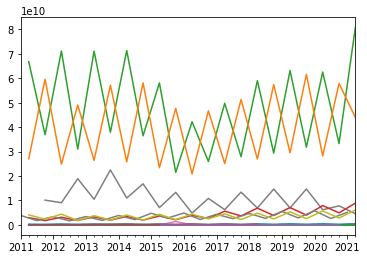

In [139]:
fig, ax = plt.subplots()

for workbook in workbooks_combined:
    if 'Operating Revenue' in workbooks_combined[workbook]['Profit Loss']:
        workbooks_combined[workbook]['Profit Loss']['Operating Revenue'].plot()


Line graph based on the operating revenue in the Profit Loss worksheet for companies across both half and full yearly datasets.

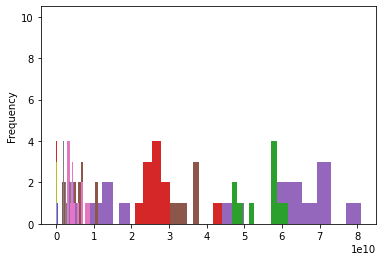

In [140]:
fig, ax = plt.subplots()

for workbook in workbooks_separated:
    for period in workbooks_separated[workbook]:
         if 'Operating Revenue' in workbooks_separated[workbook][period]['Profit Loss']:
                workbooks_separated[workbook][period]['Profit Loss']['Operating Revenue'].plot.hist()
   


Histogram based on the operating revenue in the Profit Loss worksheet for companies across both half and full yearly datasets.

[Text(0, 0, '12/01/15'),
 Text(1, 0, '12/01/16'),
 Text(2, 0, '12/01/17'),
 Text(3, 0, '12/01/18'),
 Text(4, 0, '12/01/19'),
 Text(5, 0, '12/01/20')]

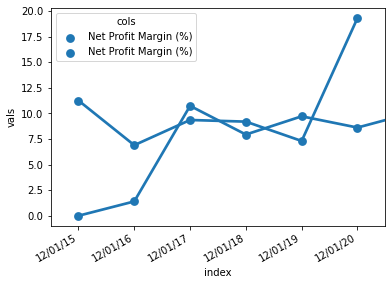

In [141]:
fig, ax = plt.subplots()

test = workbooks_separated['ADH']['FY']['Ratio Analysis'].reset_index().melt('index', var_name='cols',  value_name='vals')
test = test[test['cols'] == 'Net Profit Margin (%)']
test['index'] = test['index'].dt.strftime("%m/%d/%y")

test2 = workbooks_separated['ADH']['HY']['Ratio Analysis'].reset_index().melt('index', var_name='cols',  value_name='vals')
test2 = test2[test2['cols'] == 'Net Profit Margin (%)']
test2['index'] = test2['index'].dt.strftime("%m/%d/%y")



g = sns.pointplot(x="index", y="vals", hue='cols', data=test, kind='point', ha='center', ax=ax)
g.set_xticklabels(g.get_xticklabels(), rotation=30, ha='right')

g2 = sns.pointplot(x="index", y="vals", hue='cols', data=test2, kind='point', ha='center', ax=ax)
g2.set_xticklabels(g2.get_xticklabels(), rotation=30, ha='right')




This example is based specifically on the ADH (Adairs Ltd), half yearly and full yearly financial statement. It looks at the Ratio Analysis worksheet in the dataset, as this will later be used to create further models. The Ratio Analysis worksheet is essential when calculating the Beneish M-Score. The line plot above indicates various years of growths and drops which will be further investigated using Beneish M-Score statistical model.

## Beneish M-Score

### 1. DSRI

In [142]:
def calc_DSRI(company):
    res = {}
    days_receivables = []
    if 'Days Receivables' in company['Ratio Analysis']:
        days_receivables = company['Ratio Analysis']['Days Receivables']
    
    for row in range(1, len(days_receivables)):
        t1 = days_receivables.iloc[row]
        t0 = days_receivables.iloc[row-1]
        res[days_receivables.index[row]] = t1/t0
        
    return pd.Series(res)

The function calc_DSRI is used to calculate the Days Sales in Receivables Index using the array days_receivables to calculate the ratio of days sales in receivables for a particular period(t1) by the previous period(t0) in the specified worksheet.

<AxesSubplot:>

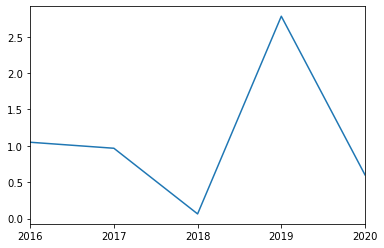

In [143]:
calc_DSRI(workbooks_separated['ADH']['HY']).plot()

The example used here is for ADH Half yearly dataset. The line plot indicates a drop in days receivables in 2018 followed by a drastic increase in 2019 which means there is a possibilty of revenue manipulation.

### 2. GMI

In [4]:
def calc_GMI(company):
    res = {}
    profit_margin = []
    if 'Net Profit Margin (%)' in company['Ratio Analysis']:
        profit_margin = company['Ratio Analysis']['Net Profit Margin (%)']
    
    for row in range(1, len(profit_margin)):
        t1 = profit_margin.iloc[row]
        t0 = profit_margin.iloc[row-1]
        res[profit_margin.index[row]] = t0/t1
        
    return pd.Series(res)

The net profit margin was used instead of the the Gross Margin for the calculation of Gross Margin  Index which is found on the Ratio Analysis worksheet. It is calculated by dividing the prior period gross margin(t0) by current period gross margin(t1).

<AxesSubplot:>

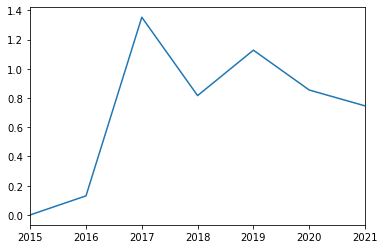

In [145]:
calc_GMI(workbooks_separated['ADH']['FY']).plot()

The company used here is ADH and its full yearly data. The line plot shows that there was a drastic increase in the net profit in 2017 followed by a flucatiion in the index, which could indicate a deep look into the profits might be necessary to get a better understanding of the company's financial situation.

### 3. AQI

In [146]:
def calc_AQI(company):
    res = {}
    bs = company['Balance Sheet']
    
    for row in range(1, len(bs)):
        if 'NCA - PP&E' not in bs or 'Total Current Assets' not in bs or 'Total Assets' not in bs:
            res[bs.index[row]] = np.nan
            continue
            
        t1 = bs.iloc[row]
        t0 = bs.iloc[row-1]
        
        aq1 = t1['Total Assets'] - (t1['Total Current Assets']+ t1['NCA - PP&E'])
        aq1 = aq1 / t1['Total Assets']
        
        aq0 = t0['Total Assets'] - (t0['Total Current Assets']+ t0['NCA - PP&E'])
        aq0 = aq0 / t0['Total Assets']
                
        res[bs.index[row]] = aq1/aq0
        
    return pd.Series(res)

The Asset Quality Index is calcualted using the non-current assets, PP&E and total assets which are found on the 'Balance Sheet' worksheet in the dataset. The Asset Quality(aq) Index requires the Asset Quality to be calculated using the formula(Total Assets - (Current Assets +PP&E)/ Total Assets) and the new AQ(aq1) is divided by prior AQ (aq0).

<AxesSubplot:>

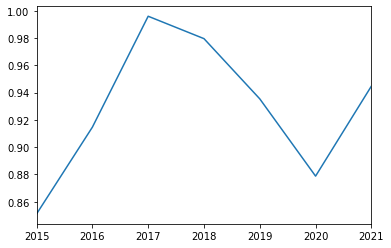

In [147]:
calc_AQI(workbooks_separated['ADH']['FY']).plot()

The line plot above is used for ADH full year and there seems to be a rise in the year 2017 and drop in the year 2021. This index could suggest any excessive capitalization of costs within the company for a particular period in the financial statement.

### 4. SGI

In [148]:
def calc_SGI(company):
    res = {}
    totrev = []
    if 'Total Revenue Excluding Interest' in company['Profit Loss']:
        totrev = company['Profit Loss']['Total Revenue Excluding Interest']

    for row in range(1, len(totrev)):
        t1 = totrev.iloc[row]
        t0 = totrev.iloc[row-1]
        
        if t1 != 0 and t0 != 0:
            res[totrev.index[row]] = t1/t0
        else:
            res[totrev.index[row]] = np.nan
    return pd.Series(res)

Sales Growth Index is computed using the company's sales(revenue) for the current period(t1) by the sales(revenue) of the previous period(t0). The feature used to calculate the SGI is 'Total Revenue Excluding Interest' from the 'Profit Loss' worksheet.

<AxesSubplot:>

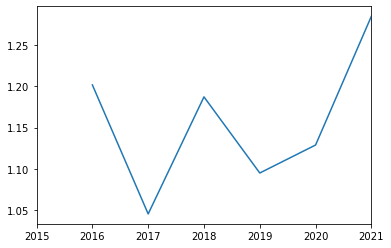

In [149]:
calc_SGI(workbooks_separated['ADH']['FY']).plot()

The line plot for ADH full yearly SGI calculation indicates that there are drastic changes in between each period which could suggest that there is some manipulation trying to meet earnings targets or high capital needs and needs to be closely monitored.

### 5. DEPI

In [150]:
def calc_DEPI(company):
    res = {}
    bs = company['Balance Sheet']
    inc = company['Profit Loss']
    
    for row in range(1, len(bs)):
        if 'Depreciation' not in inc or 'NCA - PP&E' not in bs:
            res[bs.index[row]] = np.nan
            continue
            
        bs1 = bs.iloc[row]
        bs0 = bs.iloc[row-1]
        
        inc1 = inc.iloc[row]
        inc0 = inc.iloc[row-1]
        
        dep1 = inc1['Depreciation']
        dep1 = dep1 / (inc1['Depreciation'] + bs1['NCA - PP&E'])
        
        dep0 = inc0['Depreciation']
        dep0 = dep0 / (inc0['Depreciation'] + bs0['NCA - PP&E'])
        
        res[bs.index[row]] = dep0/dep1
        
    return pd.Series(res)

The Depreciation Index represents the ratio of depreciation of the current period(dep1) from the previous period(dep0). To find the depreciation rate, the data for ‘Depreciation’ from the ‘Profit Loss’ sheet and ‘PP&E’ from the ‘BalanceSheet’ is used. 

Depreciation Rate = Depreciation/ (Depreciation + PP&E) 

<AxesSubplot:>

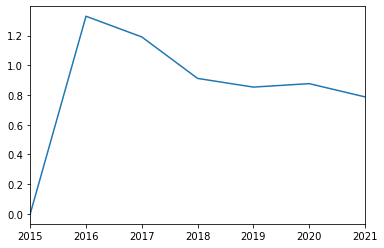

In [151]:
calc_DEPI(workbooks_separated['ADH']['FY']).plot()

In this line plot for ADH full yearly data, the ratio being greater than 1 indicates that the depreciation rate has lowered which could reflect the increase in income due to policy changes or adopting new methods within that period.

### 6. SGAI

In [152]:
def calc_SGAI(company):
    res = {}
    inc = company['Profit Loss']
    
    for row in range(1, len(inc)):
        if 'Total Revenue Excluding Interest' not in inc or 'Operating Expenses' not in inc:
            res[inc.index[row]] = np.nan
            continue
            
        t1 = inc.iloc[row]
        t0 = inc.iloc[row-1]
        
        sga1 = t1['Operating Expenses']
        sga1 = sga1 / t1['Total Revenue Excluding Interest']
        
        sga0 = t0['Operating Expenses']
        sga0 = sga0 / t0['Total Revenue Excluding Interest']
        
        res[inc.index[row]] = sga1/sga0
       
    return pd.Series(res)

The Sales, General & Administrative Expenses Index is measured using the ratio of SGA expenses for the current period(sga1) over the prior(sga2). The ‘Profit Loss’ sheet from the financial statement of each company was used to select the ‘Operating Expense’ and ‘Total Revenue Excluding Interest’.

<ipython-input-152-f561fc9fbb83>:17: RuntimeWarning: invalid value encountered in double_scalars
  sga0 = sga0 / t0['Total Revenue Excluding Interest']


<AxesSubplot:>

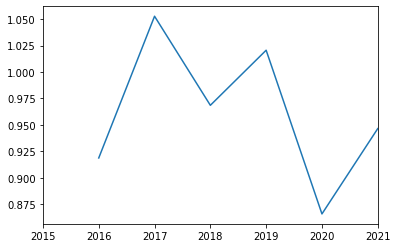

In [153]:
calc_SGAI(workbooks_separated['ADH']['FY']).plot()

When the efficiency of SGAI decreases, it could make companies predisposed to manipulating earnings, this can be seen in ADH full year statement in the year 2020.

### 7. TATA

In [154]:
def calc_TATA(company):
    resList = {}
    for year in company['Profit Loss'].index:
        incs = company['Profit Loss'].loc[year]
        bs = company['Balance Sheet'].loc[year]
        cf = company['Cash Flow'].loc[year]
        
        if 'PreTax Profit' not in incs or 'Net Operating Cashflows' not in cf or 'Net Investing Cashflows' not in cf or 'Total Assets' not in bs:
            resList[year] = np.nan
            continue

        res = incs['PreTax Profit'] - cf['Net Operating Cashflows'] - cf['Net Investing Cashflows']
        res = res / bs['Total Assets']
        resList[year] = res

    return pd.Series(resList)

Total Accruals to Total Assets focuses on the cash flow of the company against the total assets. There are a new sheets that are necessary to calculate the TATA, from the ‘Profit Loss’ sheet ‘PreTax Profit’, from ‘Cash Flow’ sheet ‘Net Operating Cashflows’ and ‘Net Investing Cashflows’ and finally ‘Total Assets’ from ‘Balance Sheet’.

The following formula is used.
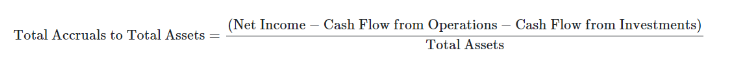

<AxesSubplot:>

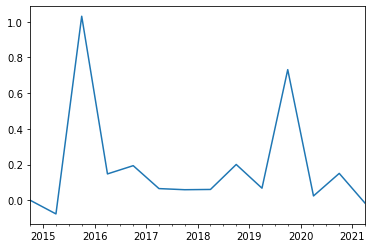

In [155]:
calc_TATA(workbooks_combined['ADH']).plot()

The TATA looks at non-cash earnings and indicates that a higher positive accruals means higher likelihood of earnings manipulation. On this line plot of ADH there are high raises in the year 2016 and 2020.

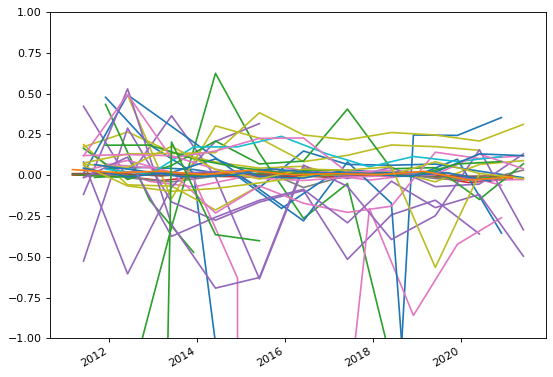

In [156]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)
ax.set_ylim(-1, 1)

for workbook in workbooks_separated:
    for period in workbooks_separated[workbook]:
        res = calc_TATA(workbooks_separated[workbook][period])
        res.plot(ax=ax)


This graph indicates that the variance in the data between the different companies is pretty high and it can be notes that the more erratic TATA seem to have a larger impact on the m-score output.

### 8. LVGI

In [157]:
def calc_LVGI(company):
    res = {}
    bs = company['Balance Sheet']
    for row in range(1, len(bs)):
        if 'NCL - Long-Term Debt' not in bs or 'Total Curr. Liabilities' not in bs or 'Total Assets' not in bs:
            res[bs.index[row]] = np.nan
            continue
            
        t1 = bs.iloc[row]
        t0 = bs.iloc[row-1]
        
        lev1 = t1['NCL - Long-Term Debt'] + t1['Total Curr. Liabilities']
        lev1 = lev1 / t1['Total Assets']
        
        lev0 = t0['NCL - Long-Term Debt'] + t0['Total Curr. Liabilities']
        lev0 = lev0 / t0['Total Assets']
                
        res[bs.index[row]] = lev1/lev0
        
    return pd.Series(res)

The Leverage Index is a ratio based on the current period(lev1) Leverage and the prior period Leverage(lev0). To compute the Leverage ‘NCL - Long-Term Debt’, ‘Total Current Liabilities’  and ‘Total Assets’ from the Balance Sheet of each company is required. 

The following formula was used to calculate LVGI:

            Leverage = (Long term debt + current liabilities) / Total assets 

<AxesSubplot:>

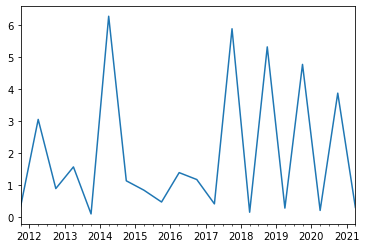

In [158]:
calc_LVGI(workbooks_combined['BCI']).plot()

Using the BCI (BCI Minerals Ltd) financial data, there are various high peaks which indicate higher the leverage ratio,which means the higher the possibility of the company being involved in financial fraud.

### M-Score

In [159]:
dsri = calc_DSRI(workbooks_combined['REX'])
gmi = calc_GMI(workbooks_combined['REX'])
aqi = calc_AQI(workbooks_combined['REX'])
sgi = calc_SGI(workbooks_combined['REX'])
sgai = calc_SGAI(workbooks_combined['REX'])
tata = calc_TATA(workbooks_combined['REX'])
lvgi = calc_LVGI(workbooks_combined['REX'])

In [160]:
def calc_mscore(company):
    res = {}
    dsri = calc_DSRI(company).replace([np.inf, -np.inf], np.nan).fillna(0)
    gmi = calc_GMI(company).replace([np.inf, -np.inf], np.nan).fillna(0)
    aqi = calc_AQI(company).replace([np.inf, -np.inf], np.nan).fillna(1)
    sgi = calc_SGI(company).replace([np.inf, -np.inf], np.nan).fillna(0)
    depi = calc_DEPI(company).replace([np.inf, -np.inf], np.nan).fillna(1)
    sgai = calc_SGAI(company).replace([np.inf, -np.inf], np.nan).fillna(1)
    tata = calc_TATA(company).replace([np.inf, -np.inf], np.nan).fillna(0)
    lvgi = calc_LVGI(company).replace([np.inf, -np.inf], np.nan).fillna(0)
    
    if len(dsri) == 0:
        dsri = pd.Series([0 for i in range(len(lvgi))])
    if len(gmi) == 0:
        gmi = pd.Series([0 for i in range(len(lvgi))])
    if len(sgi) == 0:
        sgi = pd.Series([0 for i in range(len(lvgi))])
    
    for row in reversed(range(len(lvgi))):
        mscore = -4.84 + 0.92*dsri.iloc[row] + 0.528*gmi.iloc[row] + 0.404*aqi.iloc[row] + 0.892*sgi.iloc[row] + 0.115*depi.iloc[row] -0.172*sgai.iloc[row] + 4.679*tata.iloc[row] -0.327*lvgi.iloc[row]
        
        res[lvgi.index[row]] = mscore
        
    return pd.Series(res)

In [161]:
def calc_mscore_TF(company):
    res = {}
    dsri = calc_DSRI(company).replace([np.inf, -np.inf], np.nan).fillna(0)
    gmi = calc_GMI(company).replace([np.inf, -np.inf], np.nan).fillna(0)
    aqi = calc_AQI(company).replace([np.inf, -np.inf], np.nan).fillna(1)
    sgi = calc_SGI(company).replace([np.inf, -np.inf], np.nan).fillna(0)
    depi = calc_DEPI(company).replace([np.inf, -np.inf], np.nan).fillna(1)
    sgai = calc_SGAI(company).replace([np.inf, -np.inf], np.nan).fillna(1)
    tata = calc_TATA(company).replace([np.inf, -np.inf], np.nan).fillna(0)
    lvgi = calc_LVGI(company).replace([np.inf, -np.inf], np.nan).fillna(0)
    
    if len(dsri) == 0:
        dsri = pd.Series([0 for i in range(len(lvgi))])
    if len(gmi) == 0:
        gmi = pd.Series([0 for i in range(len(lvgi))])
    if len(sgi) == 0:
        sgi = pd.Series([0 for i in range(len(lvgi))])
    
    for row in reversed(range(len(lvgi))):
        mscore = -4.84 + 0.92*dsri.iloc[row] + 0.528*gmi.iloc[row] + 0.404*aqi.iloc[row] + 0.892*sgi.iloc[row] + 0.115*depi.iloc[row] -0.172*sgai.iloc[row] + 4.679*tata.iloc[row] -0.327*lvgi.iloc[row]
        
        res[lvgi.index[row]] = 1 if (mscore > -1.78) else 0
        
    return pd.Series(res)

In [162]:
calc_mscore(workbooks_combined['ADH'])

<ipython-input-142-7c8f25b75434>:10: RuntimeWarning: divide by zero encountered in double_scalars
  res[days_receivables.index[row]] = t1/t0
<ipython-input-152-f561fc9fbb83>:17: RuntimeWarning: invalid value encountered in double_scalars
  sga0 = sga0 / t0['Total Revenue Excluding Interest']


2021-06-01   -2.44
2020-12-01   -6.52
2020-06-01    0.25
2019-12-01   -6.01
2019-06-01   -1.88
2018-12-01   -4.98
2018-06-01   -2.61
2017-12-01   -4.47
2017-06-01   -2.35
2016-12-01   -3.08
2016-06-01    5.82
2015-12-01   -4.76
2015-06-01   -4.99
dtype: float64

In [163]:
calc_mscore_TF(workbooks_combined['ANZ'])

<ipython-input-142-7c8f25b75434>:12: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(res)
<ipython-input-148-24fd3350bc9e>:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(res)
<ipython-input-154-a0a589fb5363>:13: RuntimeWarning: divide by zero encountered in double_scalars
  res = res / bs['Total Assets']


2021-03-01    0
2020-09-01    0
2020-03-01    0
2019-09-01    0
2019-03-01    0
2018-09-01    0
2018-03-01    0
2017-09-01    0
2017-03-01    0
2016-09-01    0
2016-03-01    0
2015-09-01    0
2015-03-01    0
2014-09-01    0
2014-03-01    0
2013-09-01    0
2013-03-01    0
2012-09-01    0
2012-03-01    0
2011-09-01    0
dtype: int64

<ipython-input-142-7c8f25b75434>:10: RuntimeWarning: divide by zero encountered in double_scalars
  res[days_receivables.index[row]] = t1/t0
<ipython-input-152-f561fc9fbb83>:17: RuntimeWarning: invalid value encountered in double_scalars
  sga0 = sga0 / t0['Total Revenue Excluding Interest']
<ipython-input-142-7c8f25b75434>:12: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(res)
<ipython-input-148-24fd3350bc9e>:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(res)
<ipython-input-154-a0a589fb5363>:13: RuntimeWarning: divide by zero encountered in double_scalars
  res = res / bs['Total Assets']
<ipython-input-144-b4d8995c83ff>:10: RuntimeWarning: divide by zero encountered in double_scalars
  res[profit_margin.inde

<ipython-input-148-24fd3350bc9e>:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(res)
<ipython-input-154-a0a589fb5363>:13: RuntimeWarning: divide by zero encountered in double_scalars
  res = res / bs['Total Assets']
<ipython-input-142-7c8f25b75434>:10: RuntimeWarning: divide by zero encountered in double_scalars
  res[days_receivables.index[row]] = t1/t0
<ipython-input-144-b4d8995c83ff>:10: RuntimeWarning: invalid value encountered in double_scalars
  res[profit_margin.index[row]] = t0/t1
<ipython-input-142-7c8f25b75434>:10: RuntimeWarning: divide by zero encountered in double_scalars
  res[days_receivables.index[row]] = t1/t0
<ipython-input-144-b4d8995c83ff>:10: RuntimeWarning: invalid value encountered in double_scalars
  res[profit_margin.index[row]] = t0/t1
<ipython-input-157-70cc059f5edf>:18: RuntimeWarning: divide by zero encountered in dou

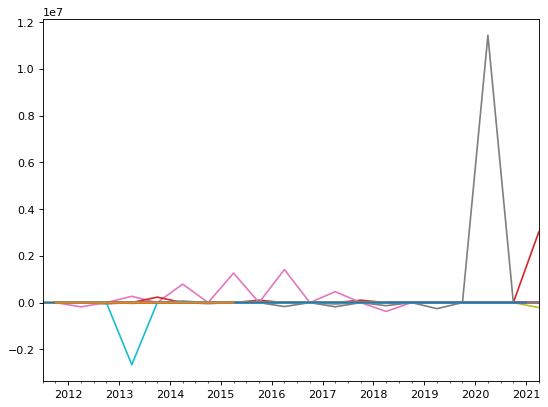

In [170]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)

for company in workbooks_combined:
    res = calc_mscore(workbooks_combined[company])
    res.plot(ax=ax)


In [172]:
for company in workbooks_combined:
    res = calc_mscore(workbooks_combined[company])
    print(company, max(res))

<ipython-input-142-7c8f25b75434>:10: RuntimeWarning: divide by zero encountered in double_scalars
  res[days_receivables.index[row]] = t1/t0
<ipython-input-152-f561fc9fbb83>:17: RuntimeWarning: invalid value encountered in double_scalars
  sga0 = sga0 / t0['Total Revenue Excluding Interest']
<ipython-input-142-7c8f25b75434>:12: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(res)
<ipython-input-148-24fd3350bc9e>:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(res)
<ipython-input-154-a0a589fb5363>:13: RuntimeWarning: divide by zero encountered in double_scalars
  res = res / bs['Total Assets']
<ipython-input-144-b4d8995c83ff>:10: RuntimeWarning: divide by zero encountered in double_scalars
  res[profit_margin.inde

ADH 5.823111928713144
ANZ -2.8954904679376074
BCI 17104.497651570848
BFG 102969.85206912822
BHP 25.82172201480914
BNL 29461.81599482683
BPG 1413659.7079953651
BTR 1495.8885099481595
CBA 125.76024324324325
CCC 5500.456579576807
CIM 68.42940992160067
CVR 13.982255132039345
DGX 14416.057275817779


<ipython-input-150-a3c690ce467f>:18: RuntimeWarning: invalid value encountered in double_scalars
  dep1 = dep1 / (inc1['Depreciation'] + bs1['NCA - PP&E'])
<ipython-input-150-a3c690ce467f>:23: RuntimeWarning: divide by zero encountered in double_scalars
  res[bs.index[row]] = dep0/dep1
<ipython-input-152-f561fc9fbb83>:14: RuntimeWarning: divide by zero encountered in double_scalars
  sga1 = sga1 / t1['Total Revenue Excluding Interest']
<ipython-input-152-f561fc9fbb83>:17: RuntimeWarning: divide by zero encountered in double_scalars
  sga0 = sga0 / t0['Total Revenue Excluding Interest']
<ipython-input-157-70cc059f5edf>:18: RuntimeWarning: divide by zero encountered in double_scalars
  res[bs.index[row]] = lev1/lev0
<ipython-input-142-7c8f25b75434>:10: RuntimeWarning: divide by zero encountered in double_scalars
  res[days_receivables.index[row]] = t1/t0
<ipython-input-144-b4d8995c83ff>:10: RuntimeWarning: invalid value encountered in double_scalars
  res[profit_margin.index[row]] = t0/t

DTZ 3018298.9582585413
GMN 413.57310716585494
HWK 44.355867006475165
JBH 4.80387673180843
LCT 11432303.146662287
MEB 15.412565751877798
MFG -2.7043262652951725
MGC 499.104846533048
MQG -0.495849305302161
NAB 3432.622416666667
NCM 21.172629498365065
NGI 468.24438240982977
REX 126.129760030054
RIO 7.530699072643331
RNO 66171.4963181062
SRX 285.7544201265204
SRZ 75.02240820500884
WBC 705.5563904761905
WCC 290.1884696346804


<ipython-input-142-7c8f25b75434>:10: RuntimeWarning: divide by zero encountered in double_scalars
  res[days_receivables.index[row]] = t1/t0
<ipython-input-144-b4d8995c83ff>:10: RuntimeWarning: invalid value encountered in double_scalars
  res[profit_margin.index[row]] = t0/t1
<ipython-input-142-7c8f25b75434>:10: RuntimeWarning: divide by zero encountered in double_scalars
  res[days_receivables.index[row]] = t1/t0
<ipython-input-144-b4d8995c83ff>:10: RuntimeWarning: invalid value encountered in double_scalars
  res[profit_margin.index[row]] = t0/t1
<ipython-input-157-70cc059f5edf>:18: RuntimeWarning: divide by zero encountered in double_scalars
  res[bs.index[row]] = lev1/lev0
<ipython-input-142-7c8f25b75434>:10: RuntimeWarning: divide by zero encountered in double_scalars
  res[days_receivables.index[row]] = t1/t0
<ipython-input-144-b4d8995c83ff>:10: RuntimeWarning: invalid value encountered in double_scalars
  res[profit_margin.index[row]] = t0/t1
<ipython-input-152-f561fc9fbb83>:14